<a href="https://colab.research.google.com/github/Khainguyen1349/ResearchWithGPT/blob/main/Ray_Tracing_and_PO_Modeling_of_LWA_Combined_with_Lens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = 3e8  # speed of light [m/s]
f = 15e9  # frequency [Hz]
λ0 = c / f  # wavelength in free space [m]
εr = 2.2  # relative permittivity of the dielectric
λd = λ0 / np.sqrt(εr)  # wavelength in dielectric
k0 = 2 * np.pi / λ0
kd = k0 * np.sqrt(εr)

# Antenna geometry
LA = 0.30  # LWA arc length [m]
R_LWA = 0.67  # radius of curvature of the LWA [m]
num_rays = 200  # number of rays/ray tubes

# Leaky-mode parameters (normalized wavenumber from paper)
beta_k0 = 0.9 # 0.53
alpha_k0 = 0.0089
beta = beta_k0 * k0
alpha = alpha_k0 * k0

In [2]:
# Total angular span of the LWA arc
theta_arc = LA / R_LWA  # in radians

In [3]:
# Center of the LWA arc below the origin for concave shape
theta_LWA = np.linspace(-LA / (2 * R_LWA), LA / (2 * R_LWA), num_rays)

# Concave arc (bowl shape): y-values bend down from the center
xk = R_LWA * np.sin(theta_LWA)                   # left to right arc
yk = -R_LWA * (1 - np.cos(theta_LWA))           # bend downward

# Surface normal at each point points radially outward from center of arc
uk = np.array([np.cos(theta_LWA), -np.sin(theta_LWA)])  # shape: (2, num_rays)

In [4]:
theta_k = np.arcsin(beta / kd)  # angle of ray wrt surface normal
ϕd_k = theta_LWA + theta_k  # angle with respect to y-axis

# Convert to unit vectors (direction of rays in dielectric)
σk = np.array([np.sin(ϕd_k), np.cos(ϕd_k)])  # shape: (2, num_rays)

In [5]:
# Circular lens definition
RL = 0.30  # lens radius [m]
lens_center = np.array([0, 0])  # for simplicity

def intersect_ray_circle(x0, y0, dx, dy, R):
    """
    Find intersection of ray (x0,y0) in direction (dx,dy) with circle of radius R centered at origin.
    Returns intersection coordinates (x, y).
    """
    a = dx**2 + dy**2
    b = 2 * (x0 * dx + y0 * dy)
    c = x0**2 + y0**2 - R**2
    discriminant = b**2 - 4 * a * c
    t = (-b + np.sqrt(discriminant)) / (2 * a)
    return x0 + t * dx, y0 + t * dy

# Find all ray intersections
χk = np.array([
    intersect_ray_circle(xk[i], yk[i], σk[0, i], σk[1, i], RL)
    for i in range(num_rays)
]).T  # shape: (2, num_rays)

In [6]:
nk = χk / np.linalg.norm(χk, axis=0)  # normalized surface normal at each χk

In [7]:
cos_φi_k = np.sum(nk * σk, axis=0)
sin_φi_k = σk[0, :] * nk[1, :] - σk[1, :] * nk[0, :]  # signed 2D cross product #np.sqrt(1 - cos_φi_k**2)

# Snell's Law: sin(φr) = sqrt(εr) * sin(φi)
sin_φr_k = np.sqrt(εr) * sin_φi_k
φr_k = np.arcsin(sin_φr_k)

# Refracted direction (in air)
ϕn_k = np.arctan2(nk[0, :], nk[1, :]) #np.sum(nk * np.array([0, 1]).reshape(2, 1), axis=0))  # angle of normal wrt y-axis
ϕ0_k = ϕn_k + φr_k  # final direction

# Unit vector in free space
sk = np.array([np.sin(ϕ0_k), np.cos(ϕ0_k)])

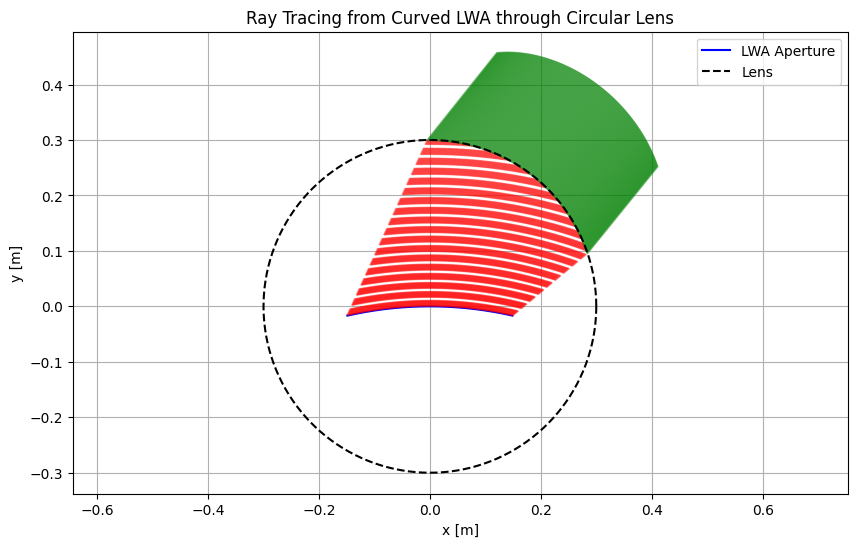

In [8]:
plt.figure(figsize=(10, 6))
# LWA
plt.plot(xk, yk, label="LWA Aperture", color='blue')

# Rays inside lens
for i in range(num_rays):
    plt.plot([xk[i], χk[0, i]], [yk[i], χk[1, i]], 'r--', alpha=0.5)

# Rays outside lens
for i in range(num_rays):
    x_end = χk[0, i] + sk[0, i] * 0.2
    y_end = χk[1, i] + sk[1, i] * 0.2
    plt.plot([χk[0, i], x_end], [χk[1, i], y_end], 'g-', alpha=0.5)

# Lens boundary
θ_lens = np.linspace(0, 2 * np.pi, 300)
plt.plot(RL * np.cos(θ_lens), RL * np.sin(θ_lens), 'k--', label="Lens")

plt.axis("equal")
plt.title("Ray Tracing from Curved LWA through Circular Lens")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
i =90
print(f"theta_LWA: {np.rad2deg(theta_LWA[i])}")
print(f"theta_k: {np.rad2deg(theta_k)}")
print(f"ϕd_k: {np.rad2deg(ϕd_k[i])}")
print(f"[xk,yk] = [{xk[i],yk[i]}]")
print(f"Surface normal direction: {uk[:,i]}")
print(f"χk: {χk[:,i]}")
print(f"Incident angle arriving at the lens'surface: {np.rad2deg(np.arcsin(sin_φi_k[i]))}")
print(f"Normal vector to the lens' surface: {nk[:,i]}")
print(f"Normal angle to the lens' surface: {np.rad2deg(ϕn_k[i])}")
print(f"Snell law angle: {np.rad2deg(φr_k[i])}")
print(f"Final direction angle: {np.rad2deg(ϕ0_k[i])}")

theta_LWA: -1.2247279052897668
theta_k: 37.35702947924788
ϕd_k: 36.13230157395812
[xk,yk] = [(np.float64(-0.014320517442511544), np.float64(-0.00015306018450849448))]
Surface normal direction: [0.99977155 0.02137391]
χk: [0.16749753 0.24888668]
Incident angle arriving at the lens'surface: 2.1922554846508304
Normal vector to the lens' surface: [0.5583251  0.82962225]
Normal angle to the lens' surface: 33.94004608930728
Snell law angle: 3.2525937455853207
Final direction angle: 37.1926398348926


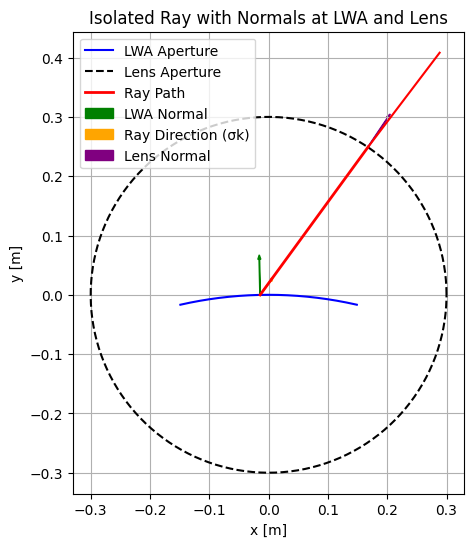

In [10]:
# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal')
ax.set_title("Isolated Ray with Normals at LWA and Lens")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

# LWA arc
ax.plot(xk, yk, color='blue', label="LWA Aperture")

# Lens boundary
theta = np.linspace(0, 2 * np.pi, 300)
lens_x = RL * np.cos(theta)
lens_y = RL * np.sin(theta)
ax.plot(lens_x, lens_y, 'k--', label="Lens Aperture")

# Selected ray path
ray_start = np.array([xk[i], yk[i]])
ray_end = χk[:, i]
ax.plot([ray_start[0], ray_end[0]], [ray_start[1], ray_end[1]], 'r-', linewidth=2, label="Ray Path")

# Normal at LWA
normal_scale = 0.03
lwa_normal_end = ray_start + normal_scale * uk[:, i]
ax.arrow(ray_start[0], ray_start[1],
         -lwa_normal_end[1] * 2 + ray_start[1] * 2, lwa_normal_end[0] *2 - ray_start[0] * 2,
         head_width=0.005, color='green', label="LWA Normal")

# Ray direction σk
ray_dir_end = ray_start + normal_scale * σk[:, i]
ax.arrow(ray_start[0], ray_start[1],
         ray_dir_end[0] - ray_start[0], ray_dir_end[1] - ray_start[1],
         head_width=0.005, color='orange', label="Ray Direction (σk)")

# Normal at lens aperture
lens_normal_end = ray_end + normal_scale * nk[:, i]
ax.arrow(ray_end[0], ray_end[1],
         lens_normal_end[0] * 2 - ray_end[0] * 2, lens_normal_end[1] * 2 - ray_end[1] * 2,
         head_width=0.005, color='purple', label="Lens Normal")

x_end = χk[0, i] + sk[0, i] * 0.2
y_end = χk[1, i] + sk[1, i] * 0.2
ax.plot([χk[0, i], x_end], [χk[1, i], y_end], 'r-')

ax.legend()
ax.grid(True)
plt.show()

In [11]:
A0 = 1.0  # normalization constant
xi_k = R_LWA * (theta_LWA + theta_arc / 2)  # approximate arc-length from start to point

A_LWA = A0 * np.sqrt(alpha) * np.exp(-alpha * xi_k)

In [12]:
# Delta lengths at source (LWA) and aperture (lens)
delta_L = np.linalg.norm(np.gradient(np.vstack((xk, yk)), axis=1), axis=0)
delta_L_prime = np.linalg.norm(np.gradient(χk, axis=1), axis=0)

# Dot products
dot_sigma_uk = np.sum(σk * uk, axis=0)
dot_sk_nk = np.sum(sk * nk, axis=0)

# Avoid division by zero
delta_L[delta_L == 0] = 1e-9
delta_L_prime[delta_L_prime == 0] = 1e-9
dot_sk_nk[np.abs(dot_sk_nk) < 1e-6] = 1e-6

# Compute aperture amplitude A'_k
A_aperture = A_LWA * np.sqrt((delta_L * dot_sigma_uk) / (delta_L_prime * dot_sk_nk))

In [13]:
#cos_phi_i_k = dot_sk_nk  # already computed
#cos_phi_r_k = np.sqrt(1 - (np.sin(np.arcsin(sin_φr_k)))**2)

Tk = 2 * cos_φi_k / (cos_φi_k + np.sqrt(1 / εr) * np.cos(φr_k))

In [14]:
A_aperture *= Tk

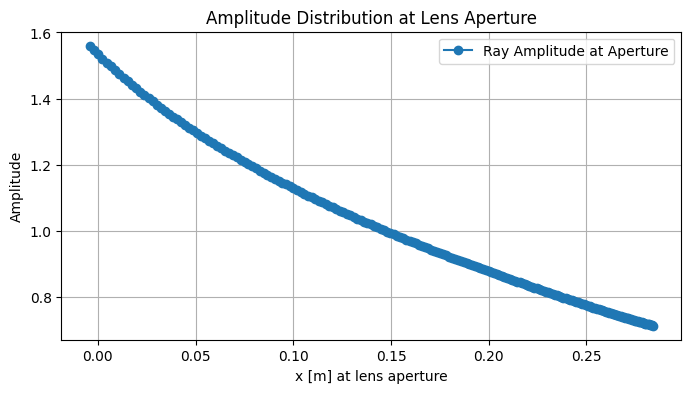

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(χk[0], A_aperture, 'o-', label="Ray Amplitude at Aperture")
plt.xlabel("x [m] at lens aperture")
plt.ylabel("Amplitude")
plt.title("Amplitude Distribution at Lens Aperture")
plt.grid(True)
plt.legend()
plt.show()

In [16]:
# Length through lens (σ_k)
sigma_k = np.linalg.norm(χk - np.vstack((xk, yk)), axis=0)  # shape: (num_rays,)

In [17]:
# Parameters
R_obs = 50.0  # observation arc radius [m]
angles_rad = np.linspace(-np.pi / 2, np.pi / 2, 500)  # observation angles

# Observation points on the arc
obs_points = R_obs * np.array([np.sin(angles_rad), np.cos(angles_rad)])  # shape (2, N_angles)

# Initialize E(θ)
E_theta = np.zeros(len(angles_rad), dtype=complex)

# Loop over rays
for k in range(num_rays):
    chi_k = χk[:, k]          # aperture point
    A_k = A_aperture[k]
    Tk_k = Tk[k]
    dL_k = delta_L_prime[k]
    s_k = sk[:, k]
    n_k = nk[:, k]
    xi = xi_k[k]
    sigma_k_val = sigma_k[k]
    base_phase = beta * xi + kd * sigma_k_val

    # Vector from aperture point to each observation point
    r_vec = obs_points - chi_k[:, np.newaxis]  # shape (2, N_angles)
    r_norm = np.linalg.norm(r_vec, axis=0)     # distance |r_k,i|
    r_hat = r_vec / r_norm                     # unit vectors (2, N_angles)

    # Phase delay from lens to observation point
    phase = base_phase + k0 * r_norm           # total phase

    # Projection term: n · s + n · r_hat (vector projection)
    proj = np.dot(n_k, s_k) + np.sum(n_k[:, np.newaxis] * r_hat, axis=0)  # (N_angles,)

    # Field contribution from this ray
    E_theta += A_k * np.exp(-1j * phase) * proj * Tk_k * dL_k

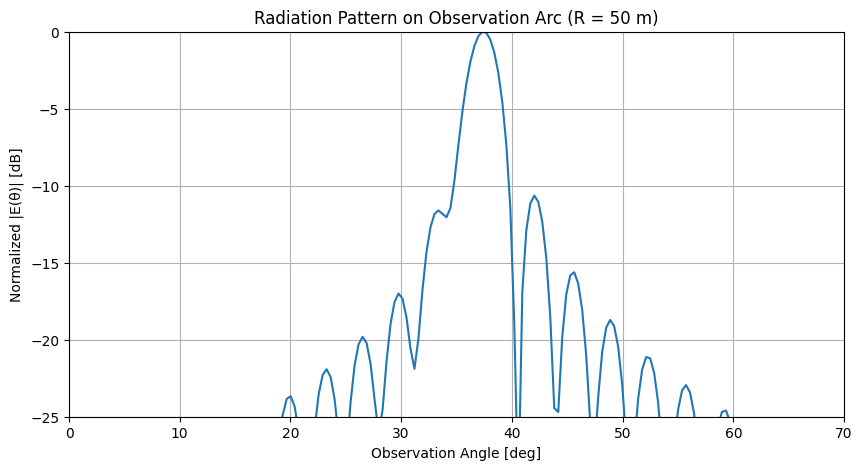

In [19]:
E_theta_norm = E_theta / np.max(np.abs(E_theta))
E_dB = 20 * np.log10(np.abs(E_theta_norm) + 1e-12)

plt.figure(figsize=(10, 5))
plt.plot(np.degrees(angles_rad), E_dB)
plt.title("Radiation Pattern on Observation Arc (R = 50 m)")
plt.xlabel("Observation Angle [deg]")
plt.ylabel("Normalized |E(θ)| [dB]")
plt.xlim(0, 70)
plt.ylim(-25, 0)
plt.grid(True)
plt.show()